In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import gensim
import spacy
import nltk

from sentimentpl.models import SentimentPLModel
import matplotlib.pyplot as plt

import re
import unicodedata
from langdetect import detect
import torch


from tqdm import tqdm
tqdm.pandas()

import sys
sys.path.append('..')

from helpers.dataset import (
    tokenize,
    filter_stop_words,
    deal_with_polish_sign,
    clean_text,
    get_stylometric_features,
    get_sentiment
)

from transformers import AutoTokenizer, AutoModel

nlp_core = spacy.load("pl_core_news_lg")
model_sent = SentimentPLModel(from_pretrained='latest')
stopwords = nlp_core.Defaults.stop_words

/home/marek/anaconda3/envs/nlp_test/lib/python3.9/site-packages/transformers/utils/generic.py:441: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
/home/marek/anaconda3/envs/nlp_test/lib/python3.9/site-packages/transformers/utils/generic.py:309: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
/home/marek/anaconda3/envs/nlp_test/lib/python3.9/site-packages/transformers/utils/generic.py:309: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
/home/marek/anaconda3/envs/nlp_test/lib/python3.9/site-packages/transformers/modeling_utils.py:484: FutureWarning: You are using `torch.load` with `weights_only=False` (the cu

In [2]:
# !pip install langdetect

# Read data & clean text

In [3]:
%%time

df_tvp = pd.read_csv('../datasets/The Polish Online News Corpus for Political Polarization Studies/data_frame_tvp_raw.csv', sep=',')
df_tvn = pd.read_csv('../datasets/The Polish Online News Corpus for Political Polarization Studies/data_frame_tvn_raw.csv', sep=',')

df_tvp['assestment'] = 1
df_tvn['assestment'] = 0

df = pd.concat(
    [
        df_tvp[['assestment', 'article']],
        df_tvn[['assestment', 'article']],
    ],
    ignore_index = True
)
print(df.shape)

df = df[df['article'].notna() ]
print(df.shape)

df = df[df['article'].apply(lambda x: len(set(x))) > 5]
print(df.shape)

df = df[df['article'].str.len() > 200 ]
print(df.shape)

(204597, 2)
(203719, 2)
(202761, 2)
(201204, 2)
CPU times: user 19.7 s, sys: 1.02 s, total: 20.7 s
Wall time: 25.4 s


In [4]:
df = df.reset_index(drop=True)

In [5]:
df = df.sample(20_000, random_state=111)

## Continue with cleaning text

In [6]:
df['words'] = df['article'].progress_apply(
    lambda x: tokenize(x, nlp_core, stopwords, join_str=None)
)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20000/20000 [13:55<00:00, 23.95it/s]


In [7]:
# df = df[df['words'].apply(len)>0]

# Look for more stopwords

In [8]:
df_one = df.copy()

df_one = df_one[['words']].reset_index().explode('words')
df_one['n'] = 1
df_one['tokens'] = df_one['words'].apply( lambda x: re.sub(r"[`'-.’0-9]", "", x) )

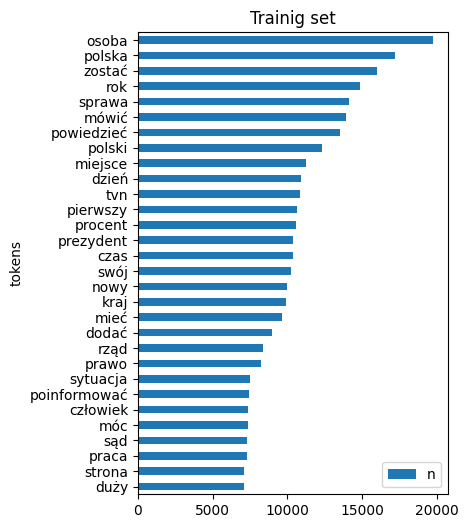

In [9]:
df_one = df_one[df_one['tokens'].str.len() > 1]

f, ax = plt.subplots(figsize=(4,6));
df_one.groupby('tokens').agg(n=('n','sum')).sort_values('n').tail(30).plot(kind='barh', ax=ax)
plt.title('Trainig set')
plt.show()

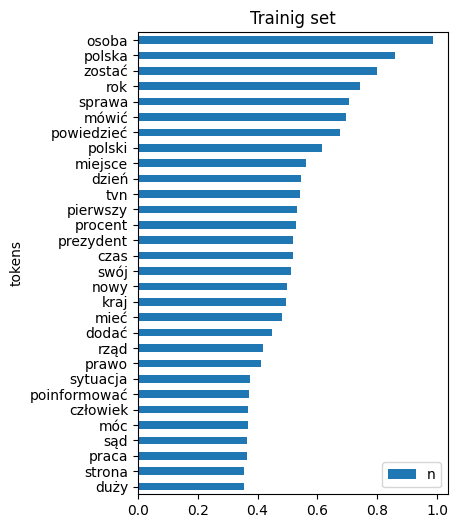

In [10]:
f, ax = plt.subplots(figsize=(4,6));
df_one_p = df_one.groupby('tokens').agg(n=('n','sum')).sort_values('n').tail(30) / df.shape[0]
df_one_p.plot(kind='barh', ax=ax)
plt.title('Trainig set')
plt.show()

In [11]:
extra_stop_words = set(['osoba', 
                        'polska', 
                        'zostać',
                        'rok',]
                       + 
                       df_one.groupby('tokens').agg(n=('n','sum')).query('n<6').index.values.tolist())

In [12]:
len(extra_stop_words)

168961

In [13]:
df['words_clean'] = df['words'].progress_apply(
    lambda x: filter_stop_words(x, extra_stop_words, ' ')
)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20000/20000 [00:00<00:00, 40174.31it/s]


## Delete rows without  any words

In [14]:
(df['words_clean'].str.len() == 0).sum()

0

In [15]:
df.shape

(20000, 4)

In [16]:
df = df[df['words_clean'].str.len() > 5].reset_index(drop=True)
df.shape

(20000, 4)

# Stylommetric features

In [17]:
df = get_stylometric_features(df,  nlp_core, model_sent, stopwords, 'words_clean', rerun_all=True)

## Get lexical features ##


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20000/20000 [00:04<00:00, 4895.96it/s]


## Vocab richness ##


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20000/20000 [07:34<00:00, 44.02it/s]


## Readability ##


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20000/20000 [00:06<00:00, 3309.47it/s]


## Extra features ##


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20000/20000 [07:29<00:00, 44.49it/s]


## Add WORDS ##


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20000/20000 [07:35<00:00, 43.90it/s]


## Add POS ##


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20000/20000 [07:28<00:00, 44.56it/s]


In [18]:
df.shape

(20000, 33)

## Save stylommetric features

In [19]:
target_column = ['assestment']

stylo_features = [
    'avg_word_len',
    'n_words', 'n_unique_words', 'p_unique_words', 'n_char',
    'n_special_char', 'avg_n_vowels_per_word', 'hapax_legomena',
    'hapax_dislegemena', 'honore_r', 'sichel_s', 'brunet_w', 'yule_k',
    'shannon_entropy', 'simpson_idx_d', 'type_token_ratio', 'FR_score',
    'FKG_level', 'Gunning_Fog_index', 
    # 'sentiment_all', 'sentiment_avg',
    'n_stop_words', 'n_ent', 'p_adj', 'n_adj', 'p_adv', 'n_adv', 'p_noun',
    'n_noun',
]

cols_for_other_f = ['text_clean', 'TEXT_WORD', 'TEXT_POS']

In [20]:
len(stylo_features)

27

In [21]:
df[target_column+stylo_features].to_parquet('../datasets/used_data/02_classical_ml/04_01_political_polarization_10p_styllometric_features.parquet')

# Ngrams POS

In [52]:
n_grams = 5
min_pos = 100 # +-5%

In [53]:
df_pos = df[target_column].copy()

words =  sum(df['TEXT_POS'].str.split(' ').values.tolist(), [])

n_list = []
for n in range(n_grams):
    n_i = pd.Series(nltk.ngrams(words, n+1)).value_counts()
    n_i = n_i[n_i>min_pos]
    n_list.append(n_i)

n_iterator = []
for n_i in n_list:
    n_iterator += n_i.index.tolist()
    
col = {}
    
for n in tqdm(n_iterator):
    x = df['TEXT_POS'].str.count(' '.join(n)) / df['TEXT_POS'].str.split(' ').str.len()

    col[' '.join(n)] = x
    col[' '.join(n)].name = ' '.join(n)
            
df_pos = pd.concat( [df_pos] + list( col.values() ), axis=1 )

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4998/4998 [33:12<00:00,  2.51it/s]


In [54]:
df_pos.shape

(20000, 4999)

In [55]:
df_pos.to_parquet('../datasets/used_data/02_classical_ml/04_02_political_polarization_10p_POS_ngrams.parquet')

# Ngram words

In [48]:
n_grams = 5
min_pos = 100

In [49]:
df_ngram = df[target_column + ['TEXT_WORD']].copy()

words =  sum(df['TEXT_WORD'].str.split(' ').values.tolist(), [])

n_list = []
for n in range(n_grams):
    n_i = pd.Series(nltk.ngrams(words, n+1)).value_counts()
    n_i = n_i[n_i>min_pos]
    n_list.append(n_i)

n_iterator = []
for n_i in n_list:
    n_iterator += n_i.index.tolist()

col = {}
    
for n in tqdm(n_iterator):
    x = df['TEXT_WORD'].str.count(' '.join(n)) / df['TEXT_WORD'].str.split(' ').str.len()

    col[' '.join(n)] = x
    col[' '.join(n)].name = ' '.join(n)
            
df_ngram = pd.concat( [df_ngram] + list( col.values() ), axis=1 )

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6535/6535 [1:07:19<00:00,  1.62it/s]


In [50]:
df_ngram.shape

(20000, 6537)

In [51]:
df_ngram.to_parquet('../datasets/used_data/02_classical_ml/04_03_political_polarization_10p_words_ngrams.parquet')

# HerBERT embeddgins

In [30]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [31]:
tokenizer = AutoTokenizer.from_pretrained("allegro/herbert-large-cased")
model = AutoModel.from_pretrained("allegro/herbert-large-cased").to(device)

/home/marek/anaconda3/envs/nlp_test/lib/python3.9/site-packages/transformers/utils/generic.py:309: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
/home/marek/anaconda3/envs/nlp_test/lib/python3.9/site-packages/transformers/modeling_utils.py:484: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via 

In [33]:
embeddings_table = np.zeros((df.shape[0], 1024))

for i, t in enumerate(tqdm(df['article'].values)):
    encoded_input = tokenizer(t, return_tensors='pt', truncation=True, padding=True).to(device)
    output = model(**encoded_input)[0][:,0]
    embeddings_table[i,:] = output.detach().to('cpu').numpy()

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20000/20000 [34:27<00:00,  9.67it/s]


In [34]:
with open('../datasets/used_data/02_classical_ml/04_05_political_polarization_10p_herbert.npy', 'wb') as f:
    np.save(f, embeddings_table)

# RoBERTa embeddgins

In [37]:
# tokenizer = AutoTokenizer.from_pretrained("sdadas/polish-roberta-large-v2")
# model = AutoModel.from_pretrained("sdadas/polish-roberta-large-v2").to(device)

In [38]:
# embeddings_table = np.zeros((df.shape[0], 1024))

# for i, t in enumerate(tqdm(df['article'].values)):
#     encoded_input = tokenizer(t, return_tensors='pt', truncation=True, padding=True).to(device)
#     output = model(**encoded_input)[0][:,0]
#     embeddings_table[i,:] = output.detach().to('cpu').numpy()

In [39]:
# with open('../datasets/used_data/02_classical_ml/04_06_political_polarization_10p_roberta.npy', 'wb') as f:
#     np.save(f, embeddings_table)